# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [88]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt
import plotly.graph_objects as go


**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

In [89]:
# Load the "Old Faithful" dataset from the Seaborn library
df = seaborn.load_dataset('geyser')
display(df)
X = df[['duration', 'waiting']].values
N, D = X.shape
print(df.describe())


# 1 ere version : Standard Scaler
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_standardized = (X - mean) / std

# 2e version : Min Max Scaler
# Appliquer la standardisation Min-Max avec numpy
#X_min = np.min(X, axis=0)
#X_max = np.max(X, axis=0)
#X_standardized = (X - X_min) / (X_max - X_min)
print(X_standardized[:5])

# Affichage graphique
fig = go.Figure(data=go.Scatter(x=X_standardized[:, 0], y=X_standardized[:, 1], mode='markers'))
fig.update_layout(title="Standardized Geyser Data",
                  xaxis_title="Duration",
                  yaxis_title="Waiting",
                  showlegend=False)
fig.show();

,duration,waiting,kind
0,3.600,79,long
1,1.800,54,short
2,3.333,74,long
3,2.283,62,short
4,4.533,85,long
...,...,...,...
267,4.117,81,long
268,2.150,46,short
269,4.417,90,long
270,1.817,46,short


         duration     waiting
count  272.000000  272.000000
mean     3.487783   70.897059
std      1.141371   13.594974
min      1.600000   43.000000
25%      2.162750   58.000000
50%      4.000000   76.000000
75%      4.454250   82.000000
max      5.100000   96.000000
[[ 0.09849886  0.59712344]
 [-1.48145856 -1.24518118]
 [-0.13586149  0.22866251]
 [-1.05750332 -0.6556437 ]
 [ 0.91744345  1.03927655]]


> On pourrait utiliser deux versions différentes de standardisation. Est ce qu'il y a un impact sur les resultats ? Nous verrons bien. 








**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [90]:
from scipy.stats import multivariate_normal

def log_likelihood(X, weights, means, covariances):
    """
    Calcule la log-vraisemblance pour un mélange de gaussiennes.

    Paramètres:
    - X: les données
    - weights: les poids des composants gaussiens
    - means: les moyennes des composants gaussiens (nombre de composants, nombre de caractéristiques)
    - covariances: les covariances des composants gaussiens (nombre de composants, nombre de caractéristiques, nombre de caractéristiques)

    Retourne:
    - La log-vraisemblance des données générées par le mélange de gaussiennes.
    """
    
    # Proba de chaque point de données pour chaque composant gaussien
    proba = np.zeros((X.shape[0], len(weights)))
    for k in range(len(weights)):
        proba[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
    
    total_proba = np.sum(proba, axis=1)
    
    return np.sum(np.log(total_proba))

In [91]:
# test sur des valeurs arbitraires. 
weights = [0.5, 0.5]
means = [[0, 0], [1, 1]]  # Ces moyennes sont choisies arbitrairement
covariances = [np.eye(2), np.eye(2)]  # Matrices d'identité pour la simplicité

ll = log_likelihood(X_standardized, weights, means, covariances)
print(f"Log-vraisemblance: {ll}") 

# conclusion : semble fonctionner correctement.

Log-vraisemblance: -790.8733976257811


**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [92]:
def EM_algorithm_v1(X, K, Niter):
    # Init des paramètres
    N, D = X.shape
    means = X[:K]
    covariances = [np.eye(D) for _ in range(K)]
    weights = [1./K] * K
    
    # Pour stocker l'évolution des valeurs de la log-vraisemblance
    log_likelihood_values = np.zeros(Niter + 1)
    log_likelihood_values[0] = log_likelihood(X, weights, means, covariances)
    
    for i in range(1, Niter+1 ):
        # E-Step
        r = np.zeros((N, K))
        for k in range(K):
            r[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
        r /= r.sum(axis=1, keepdims=True)
        
        # M-Step
        for k in range(K):
            N_k = np.sum(r[:, k])
            means[k] = 1. / N_k * np.sum(r[:, k][:, np.newaxis] * X, axis=0)
            x_diff = X - means[k]
            covariances[k] = 1. / N_k * np.dot(r[:, k] * x_diff.T, x_diff)
            weights[k] = N_k / N
        
        # log-vraisemblance pour cette itération
        log_likelihood_values[i] = log_likelihood(X, weights, means, covariances)
    
    return log_likelihood_values, weights, means, covariances

**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

In [93]:
K = 2
Niter = 50

log_likelihood_values, final_weights, final_means, final_covariances = EM_algorithm_v1(X_standardized, K, Niter)

# Afficher l'évolution de la log-vraisemblance en fonction des itérations. 

fig = go.Figure()
# Ajout de la trace pour l'évolution de la log-vraisemblance
fig.add_trace(go.Scatter(x=list(range(len(log_likelihood_values))),
                         y=log_likelihood_values,
                         mode='lines',
                         name='Log-vraisemblance'))

# Mise à jour du layout
fig.update_layout(title="Evolution de la log-vraisemblance en fonction des itérations.",
                  xaxis_title="Itérations",
                  yaxis_title="Log-vraisemblance")
fig.show()

### Observations 

>  Comme on peut constater sur l'affichage graphique, on remarque que la log-vraisemblance augmente à chaque itération, indiquant que l'algorithme EM améliore l'ajustement du mélange de gaussiennes aux données puis semble converger après quelques itérations. 

> Nous obtenons bien ce que nous voulions avec le principe de l'algorithme.


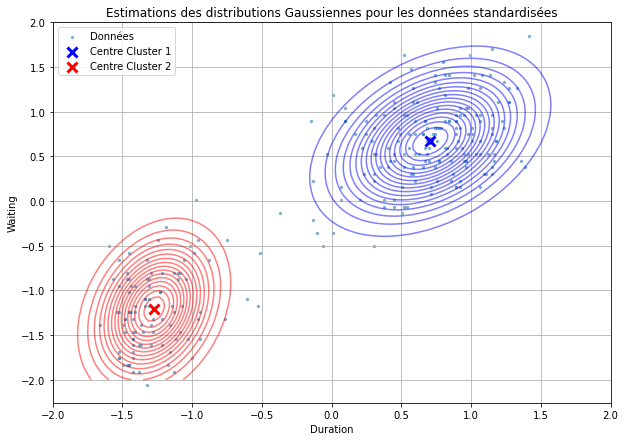

In [94]:
# Afficher le dataset et les estimations des deux lois normales
plt.figure(figsize=(10, 7))
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], s=5, label="Données", alpha=0.5)

# Créer un meshgrid pour le contour plot
x = np.linspace(-2, 2, 100)  # Ajusté pour les données standardisées
y = np.linspace(-2, 2, 100)  # Ajusté pour les données standardisées
X_mesh, Y_mesh = np.meshgrid(x, y)
pos = np.dstack((X_mesh, Y_mesh))

# Afficher les contours des deux gaussiennes
colors = ["Blue", "Red"]
for k in range(2):
    Z = multivariate_normal.pdf(pos, mean=final_means[k], cov=final_covariances[k])
    plt.contour(X_mesh, Y_mesh, Z, levels=20, alpha=0.5, colors=colors[k])
    
    # Ajouter le centre de chaque cluster avec des couleurs distinctes
    plt.scatter(final_means[k][0], final_means[k][1], color=colors[k], s=100, marker='x', label=f'Centre Cluster {k+1}', linewidths=3)

plt.title("Estimations des distributions Gaussiennes pour les données standardisées")
plt.xlabel("Duration")
plt.ylabel("Waiting")
plt.legend()
plt.grid(True)
plt.show()


> Les contours représentent les régions de densité élevée pour chaque gaussienne et entourent bien les clusters apparents dans les données standardisées. Comme la plupart des points se trouvent à l'intérieur de ces zones, cela indique que le modèle gaussien a bien capturé la densité des données.
> Les centres des gaussiennes (moyennes), representés par les marqueurs 'x' sur le graphique, indiquent les moyennes des distributions gaussiennes et sont situés près des centres des clusters apparents, ce qui prouve que l'algorithme a bien fonctionné.


**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [95]:
def EM_algorithm_v2(X, K, Niter, seed):
    # Init des paramètres
    N, D = X.shape
    covariances = [np.eye(D) for _ in range(K)]
    np.random.seed(seed)
    means=np.random.normal(0, 1, size=(K, D))
    weights=np.random.dirichlet(np.ones(K),size=1).reshape(K)
    
    # Pour stocker l'évolution des valeurs de la log-vraisemblance
    log_likelihood_values = np.zeros(Niter + 1)
    log_likelihood_values[0] = log_likelihood(X, weights, means, covariances)
    
    for i in range(1, Niter+1 ):
        # E-Step
        r = np.zeros((N, K))
        for k in range(K):
            r[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
        r /= r.sum(axis=1, keepdims=True)
        
        # M-Step
        for k in range(K):
            N_k = np.sum(r[:, k])
            means[k] = 1. / N_k * np.sum(r[:, k][:, np.newaxis] * X, axis=0)
            x_diff = X - means[k]
            covariances[k] = 1. / N_k * np.dot(r[:, k] * x_diff.T, x_diff)
            weights[k] = N_k / N
        
        # log-vraisemblance pour cette itération
        log_likelihood_values[i] = log_likelihood(X, weights, means, covariances)
    
    return log_likelihood_values, weights, means, covariances

weights: [0.35594357 0.64405643]
means: [[-1.27165243 -1.20941895]
 [ 0.70746392  0.66901073]]
covariances: [array([[0.05294206, 0.02816263],
       [0.02816263, 0.18303665]]), array([[0.12869454, 0.0604347 ],
       [0.0604347 , 0.19557417]])]
[1.90906772e-17 1.68730418e+00 1.09025179e-06 6.15321416e-01
 1.12944429e-21]


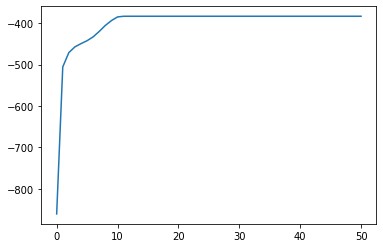

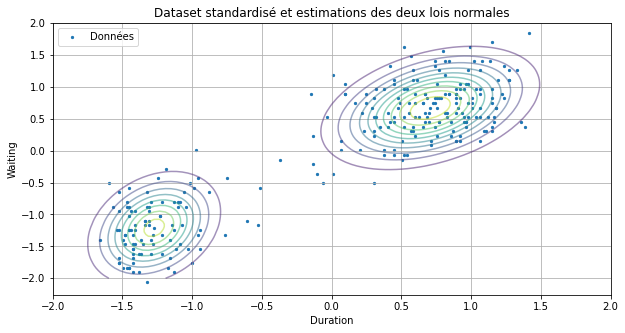

In [96]:
K = 2
Niter = 50

log_likelihood_values, final_weights, final_means, final_covariances = EM_algorithm_v2(X_standardized, K, Niter,42)

print(f"weights: {final_weights}")
print(f"means: {final_means}")
print(f"covariances: {final_covariances}")
print(multivariate_normal.pdf(X_standardized, mean=final_means[0], cov=final_covariances[0])[:5])
# Plot log-likelihood
plt.plot(log_likelihood_values)
plt.show()
# Plot data with plt.contour


# Afficher le dataset et les estimations des deux lois normales
plt.figure(figsize=(10, 5))
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], s=5, label="Données")

# Créer un meshgrid pour le contour plot
x = np.linspace(-2, 2, 100)  # Ajusté pour les données standardisées
y = np.linspace(-2, 2, 100)  # Ajusté pour les données standardisées
X_mesh, Y_mesh = np.meshgrid(x, y)
pos = np.dstack((X_mesh, Y_mesh))

# Afficher les contours des deux gaussiennes
for k in range(len(final_means)):
    Z = multivariate_normal.pdf(pos, mean=final_means[k], cov=final_covariances[k])
    plt.contour(X_mesh, Y_mesh, Z, levels=10, alpha=0.5)

plt.title("Dataset standardisé et estimations des deux lois normales")
plt.xlabel("Duration")
plt.ylabel("Waiting")
plt.legend()
plt.grid(True)
plt.show()

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

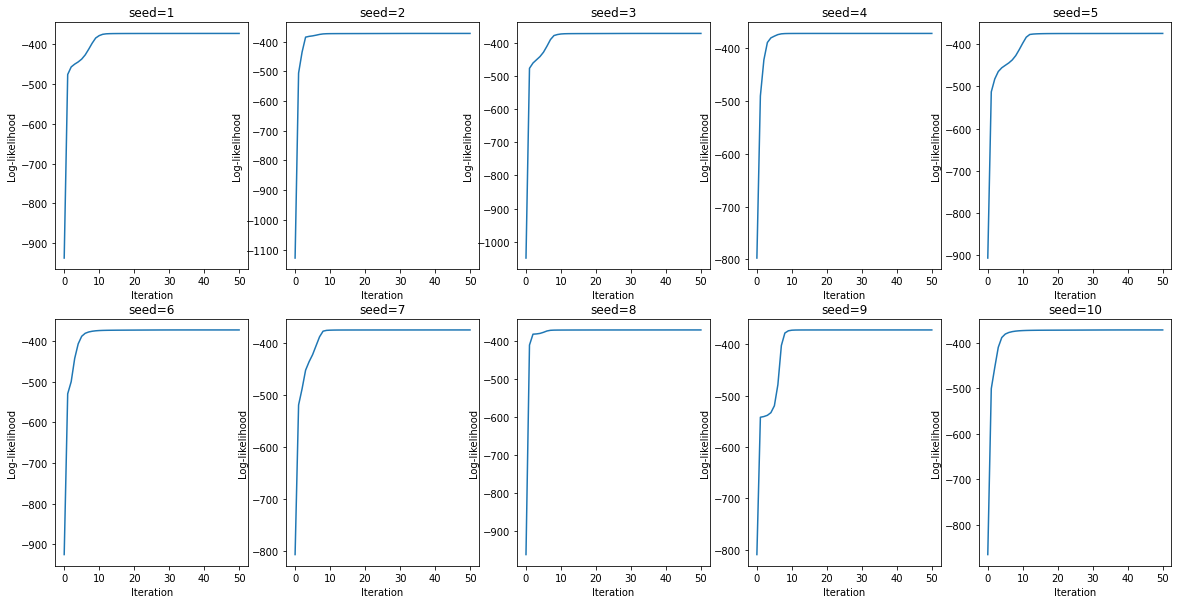

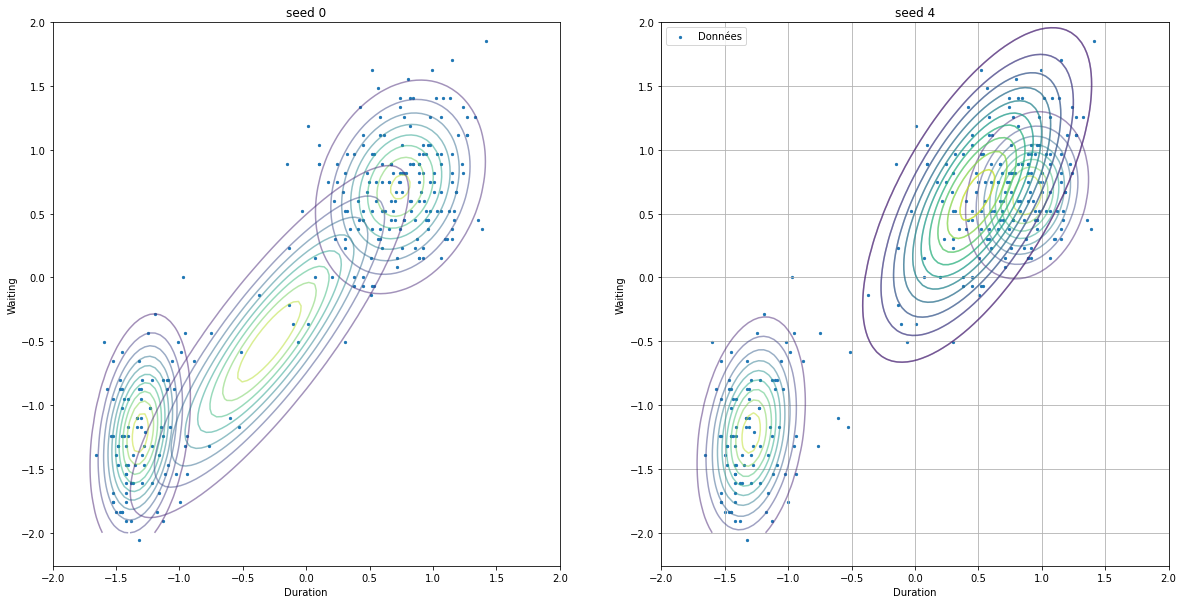

In [97]:
K = 3
 
#use subplot to plot 10 loglikelihood computed with different seeds
plt.figure(figsize=(20, 10))
means_list=[]
cov_list=[]
for i in range(1,11):
    log_likelihood_values, final_weights, final_means, final_covariances  = EM_algorithm_v2(X_standardized, K, Niter,i)
    means_list.append(final_means)
    cov_list.append(final_covariances)
    plt.subplot(2, 5, i)
    plt.plot(log_likelihood_values)
    plt.title(f"seed={i}")
    plt.xlabel("Iteration")
    plt.ylabel("Log-likelihood")
plt.show()


means_list=np.array(means_list)
cov_list=np.array(cov_list)

#compute distance between means
distances=np.zeros((10,10))
for i in range(0,10):
    for j in range(0,10):
        distances[i,j]=np.linalg.norm(means_list[i]-means_list[j])

#find the most distant means
max_dist=np.max(distances)
#find index of the most distant means
index=np.where(distances==max_dist)

#plot the distributions of the most distant means
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.xlabel("Duration")
plt.ylabel("Waiting")
plt.title("seed "+str(index[0][0]))
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], s=5, label="Données")
x = np.linspace(-2, 2, 100)  # Ajusté pour les données standardisées
y = np.linspace(-2, 2, 100)  # Ajusté pour les données standardisées
X_mesh, Y_mesh = np.meshgrid(x, y)
pos = np.dstack((X_mesh, Y_mesh))
for k in range(len(final_means)):
    Z = multivariate_normal.pdf(pos, mean=means_list[index[0][0]][k], cov=cov_list[index[0][0]][k])
    plt.contour(X_mesh, Y_mesh, Z, levels=10, alpha=0.5)


plt.subplot(1, 2, 2)
plt.xlabel("Duration")
plt.ylabel("Waiting")
plt.title("seed "+str(index[0][1]))
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], s=5, label="Données")
for k in range(len(final_means)):
    Z = multivariate_normal.pdf(pos, mean=means_list[index[0][1]][k], cov=cov_list[index[0][1]][k])
    plt.contour(X_mesh, Y_mesh, Z, levels=10, alpha=0.5)
plt.contour(X_mesh, Y_mesh, Z, levels=10, alpha=0.5)
plt.legend()
plt.grid(True)

plt.show()


    


La log-likelihood se stabilise toujours vers des valeurs proches de -380, mais la convergence se fait plus ou moins rapidement.
Nous avons afficher les deux cas avec les moyennes de gaussiennes les plus différentes, on voit qu'elles sont bel et bien très différentes. Je choisirai celle avec le moins de chevauchement.

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance de le modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

In [98]:
bic=[]
for k in range(1,7):
    log_likelihood_values, final_weights, final_means, final_covariances  = EM_algorithm_v2(X_standardized, k, Niter, 42) #seed=42 plante le bordel c est relou
    bic.append((k/2*3*4-1)*np.log(X_standardized.shape[0])-2*log_likelihood_values[-1])
print(bic)
print("on devra prendre le modèle avec K = ",np.argmin(bic)+1)


[1116.5284463154328, 828.6239303744387, 839.5813343925826, 863.1051272277302, 890.0956139246582, 903.3905284503289]
on devra prendre le modèle avec K =  2


> nombre de paramètres libres:
>
> on a K*D pour les moyennes 
>
> on a K pour les poids, car une fois les K-1 premiers fixés, et comme nous avons également la somme égale à 1, le dernier sera fixé directement aussi. 
>
> on a $K*(D+D-1+D-2+...+1)$ = $K*D*(D+1)/2$ pour les covariances (les matrices étant symétriques). 
>
> ce qui donne $K/2*(D*(D+1)+2D+2)-1=K/2*(D²+3D+2)-1=K/2*((D+1)*(D+2))-1

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.

> L'algorithme EM est une méthode itérative utilisée pour trouver des estimations de maximum de vraisemblance dans les modèles statistiques où le modèle dépend de variables cachées non observées. Il est particulièrement utile lorsque les données peuvent être modélisées comme un mélange de plusieurs distributions, comme c'est le cas avec le mélange de gaussiennes.
>
> Comme nous avons pu le voir dans ce TP, une des applications les plus courantes de l'EM est le mélange de gaussiennes, qui est souvent utilisé pour le clustering. Voici une explication détaillée de la manière dont l'algorithme EM peut être utilisé pour le clustering :
>
> Supposons que nos données soient générées à partir de plusieurs distributions gaussiennes (clusters). Chaque point de données appartient à l'un de ces clusters, mais nous ne connaissons pas cette appartenance (c'est notre variable cachée). 
>
> On pourra alors choisir un nombre K de clusters (gaussiennes) et initialiser les paramètres de chaque gaussienne(moyenne, covariance) et poids de chaque cluster.
>
> L'étape d'Expectation permet de calculer la probabilité que chaque observation provienne d'un cluster, en se basant sur les paramètres actuels de chaque gaussienne.
>
> L'étape de Maximization permet de mettre à jour les paramètres de chaque gaussienne en fonction des poids calculés à l'étape d'Expectation.
>
> Enfin, il suffira de répéter ces deux étapes de manière itérative jusqu'à ce que la log-vraisemblance des données sous le modèle actuel converge, ou jusqu'à ce que d'autres critères d'arrêt soient satisfaits. C'est la convergence. En d'autres termes, chaque point de données sera attribué au cluster pour lequel il a le poids le plus élevé. 
> Cependant, il faut faire attention car cet algorithme est sensible aux conditions initiales, peut converger vers des optima locaux, et le choix du nombre de clusters K doit être fait a priori. 

